In [ ]:
#DQN&DDQN_RIGHTONLY.ipynb trains the agent 5000 times in right only actions with DQN and DDQN algorithms.

In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
pip install gym-super-mario-bros==7.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for nes-py: filename=nes_py-8.2.1-cp38-cp38-linux_x86_64.whl size=439734 sha256=dafdd6e9286b259838418386c751cf687b7e427dfdab5097069e24f6afb046e5
  Stored in directory: /root/.cache/pip/wheels/17/e5/5c/8dfae61b44dbf56c458483aa09accef55a650e0527f6cbd872
Successfully built nes-py


In [ ]:
import torch
import torch.nn as nn
import random
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from tqdm import tqdm
import pickle
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import gym
import numpy as np
import collections
import cv2
import os
import matplotlib.pyplot as plt
from IPython import display

class MSE(gym.Wrapper):
    """
        Adjust the game screen output of the Mario game, because when playing the game, 
        the continuity of the game will make most of the continuous pictures obtained 
        within a period of time approximate. In order to reduce the input of approximate 
        game scene pictures and improve training efficiency, it will Traverse the skip 
        frame image, calculate the sum of the skip frame image rewards, and perform a 
        maximum pooling in the last 2 frames of the skip frame, and generate a frame 
        image after pooling to represent the skip frame image. At here, skip=4.
    """
    def __init__(self, env=None, skip=4):
        super(MSE, self).__init__(env)
        #for the most recent raw observation, aka for max pooling across time steps
        self.buffer_observation = collections.deque(maxlen=2)
        self.skip = skip

    def step(self, action):
        reward_total = 0.0
        for _ in range(self.skip):
            observation, reward, done, info = self.env.step(action)
            self.buffer_observation.append(observation)
            reward_total = reward_total + reward
            if done:
                break
        max_frame = np.max(np.stack(self.buffer_observation), axis=0)
        return max_frame, reward_total, done, info

    def reset(self):
        """Skip frames, and max pooling is implemented here"""
        self.buffer_observation.clear()
        observation = self.env.reset()
        self.buffer_observation.append(observation)
        return observation

class MR84x84(gym.ObservationWrapper):
    """
    Set the size of the game screen Adjust the size of the game screen 
    to 84*84 grayscale image, ie shape 84,84,1
    """

    def __init__(self, env=None):
        super(MR84x84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return MR84x84.process(obs)

    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
            # image normalization
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class imgToTorch(gym.ObservationWrapper):
    """
    Convert 84*84*1 array to 1*84*84 tensor
    """

    def __init__(self, env):
        super(imgToTorch, self).__init__(env)
        original_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(original_shape[-1], original_shape[0], original_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BW(gym.ObservationWrapper):
    """
    Function: return the picture of consecutive n_steps frames (after skip)
    Implementation: When env calls the reset() method, self.buffer will be initialized, 
    and its size will be initialized to n_steps*84*84, that is, four 1*84*84 game screens 
    can be placed. When initializing, the first three It is all 0, the last one is the initialized game screen
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BW, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        # self.env.reset() is the screen where the game starts as a parameter of self.observation
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        # Move the last three positions forward, the first position will be covered
        self.buffer[:-1] = self.buffer[1:]
        # Put observation to the last position
        self.buffer[-1] = observation
        return self.buffer

class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize 4*84*84 data so that the pixel values ​​are distributed between 0-1, a common 
    operation of convolutional neural networks
    """

    def observation(self, obs):
        normalization = np.array(obs).astype(np.float32) / 255.0
        return normalization

'''
The above classes are all inherited from the classes in gym
'''

class DQN_network(nn.Module):
    """
        The most primitive Q-learning algorithm always needs a Q table to record during the execution 
        process. When the dimension is not high, the Q table can still meet the demand, but when encountering 
        exponential dimension, the efficiency of the Q table is very high. limited. Therefore, we consider a 
        value function approximation method, so that each time we only need to know S or A in advance, we can 
        get the corresponding Q value in real time.

        Originally, the Q value was found through S (state) and A (action), but now a neural network is used to 
        obtain an approximate Q value. The neural network is very powerful, so we can directly use the game screen
        as a state S and input it into the network. We can use the output of the network as the Q value, and make 
        each output correspond to the Q value of an action A, so that we can Get the Q value of each action in state S. 
        This is DQN.

        For this Mario game, if we only look at a certain frame alone, we must be missing some relevant information. 
        For example, we cannot judge whether Mario is rising or falling through one frame. So it is estimated that if 
        several consecutive frames are input at the same time, the neural network can know whether Mario is rising or 
        falling, and it can be estimated that this will be better as an input. This is why the first few classes that 
        inherit from gym have transformed Mario's output game screen.

    This class is the construction of the convolutional neural network. The input of the convolutional neural network 
    is an 84*84*4 game scene, and the output is action_space, corresponding to the Q value of each action.    
    """

    def __init__(self, input_shape, n_actions):
        super(DQN_network, self).__init__()
        # Build convolutional layers
        self.conv = nn.Sequential(
            # input_shape[0] The number of channels of the input image, the superposition of 4 single-channel images is 4
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Get the output of the convolutional layer and expand it into 1 dimension, then input the size of the fully connected layer
        conv_out_size = self._get_conv_out(input_shape)

        # Build a fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

class DQN_agent:
    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dqn, pretrained,save_path):
        '''
            Initialization parameters:
                1. state_space: game state space, that is, the shape (4,84,84) of the game state obtained after processing the env screen above represents four consecutive game scenes
                2.action_space: game action space, that is, the number of actions RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT corresponds to 5 7 12
                3.max_memory_size: The size of the experience playback pool
                    The concept and purpose of experience playback: Reinforcement learning has stability problems due to the correlation between states, because the samples collected by 
                    the agent when exploring the environment are a time series, and there is continuity between the samples, so it is necessary to break the time correlation , the solution 
                    is to store the current training state to the memory M during training, and randomly sample mini-batches from M for updating when updating parameters.
                    Specifically, the data type stored in M is <s,a,r,s′,done>:
                        a: action performed by state s
                        s: state s before the execution of state a
                        s′: the new state s after state a is executed
                        r: the reward obtained by executing a in state s
                        done: whether the game is over
                    M has a maximum length limit to ensure that the updated data are all recent data. The ultimate goal of experience replay is to prevent overfitting.
                4. batch_size: the batch of each training, that is, each time the batch_size group data is randomly selected from the experience pool for training
                5. Gamma: 0-1
                    ddqn according to Q*(S, A) <- r + gamma * max_a Q_target(S', a)
                    dqn according to Q*(S, A) <- r + gamma * max_a Q(S', a)
                    It can be seen that the Q value is the sum of the current reward and the predicted Q value, and gamma indicates the value of the future
                6.lr: learning rate
                7. exploration_max: The probability of random exploration is the probability of taking random actions
                    Purpose: The initial network has not been trained, directly using the network output will cause the same scene to be stuck directly, so
                             Use random actions to obtain training data and explore the state space
                8.exploration_min: The lowest probability of random exploration. With the training of the network, the network will become better and better, and the space for exploration will become more and more, so
                    The probability of using random exploration needs to be slowly reduced until it falls to the preset minimum value
                9.exploration_decay: random exploration decay factor, now_exploration=exploration*exploration_decay, is a value between 0-1, less than 1
                10.double_dqn: the agent type is DDQN or DQN, the optimization goals of the two are different
                11.pretrained: whether it is a test, if it is a test, just test, no training is required
                12.save_path: test model loading path
        '''
        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dqn = double_dqn
        self.pretrained = pretrained
        # If there is a GPU, use GPU training, otherwise CPU
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Double DQN network
        if self.double_dqn:
            # Use Net to create two neural networks: evaluation network and target network
            self.local_net = DQN_network(state_space, action_space).to(self.device)
            self.target_net = DQN_network(state_space, action_space).to(self.device)
            # If it is a test, load the trained model from memory
            if self.pretrained:
                self.local_net.load_state_dict(torch.load(os.path.join(save_path,"DQN1.pt"), map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load(os.path.join(save_path,"DQN2.pt"), map_location=torch.device(self.device)))
            # Optimizer selects Adam
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            # #Copy local_net weights to target_net every 5000 steps
            self.copy = 5000
            self.step = 0
        # DQN network
        else:
            # Only need to load a network
            self.dqn = DQN_network(state_space, action_space).to(self.device)
            if self.pretrained:
                self.dqn.load_state_dict(torch.load(os.path.join(save_path,"DQN.pt"), map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)
        # Create memory
        self.max_memory_size = max_memory_size
        #The entire experience pool is composed of STATE_MEMORY ACTION_MEMORY STATE2_MEMORY REWARD_MEMORY DONE_MEMORY, each of which is a torch tensor with a length of max_memory_size
        #These five components (s, a, s', done)
        if self.pretrained:
            self.ACTION_MEMORY = torch.load(os.path.join(save_path,"ACTION_MEMORY.pt"))
            self.REWARD_MEMORY = torch.load(os.path.join(save_path,"REWARD_MEMORY.pt"))
            self.DONE_MEMORY = torch.load(os.path.join(save_path,"DONE_MEMORY.pt"))
            with open(os.path.join(save_path,"terminal_position.pkl"), 'rb') as f:
                self.terminal_position = pickle.load(f)
            with open(os.path.join(save_path,"num_in_queue.pkl"), 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.ACTION_MEMORY = torch.zeros(max_memory_size, 1)
            self.REWARD_MEMORY = torch.zeros(max_memory_size, 1)
            self.DONE_MEMORY = torch.zeros(max_memory_size, 1)
            self.terminal_position = 0
            self.num_in_queue = 0

        self.STATE_MEMORY = torch.zeros(max_memory_size, *self.state_space)
        self.STATE2_MEMORY = torch.zeros(max_memory_size, *self.state_space)
        self.memory_sample_size = batch_size

        self.gamma = gamma
        # Use Huber loss function
        self.l1 = nn.SmoothL1Loss().to(self.device)
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    # Store data to experience pool
    def remember(self, state, action, reward, state2, done):
        self.STATE_MEMORY[self.terminal_position] = state.float()
        self.ACTION_MEMORY[self.terminal_position] = action.float()
        self.REWARD_MEMORY[self.terminal_position] = reward.float()
        self.STATE2_MEMORY[self.terminal_position] = state2.float()
        self.DONE_MEMORY[self.terminal_position] = done.float()
        self.terminal_position = (self.terminal_position + 1) % self.max_memory_size
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)

    def get_batch_experiences(self):
        # Randomly batch size sample experiences
        index = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEMORY[index]
        ACTION = self.ACTION_MEMORY[index]
        REWARD = self.REWARD_MEMORY[index]
        STATE2 = self.STATE2_MEMORY[index]
        DONE = self.DONE_MEMORY[index]
        return STATE, ACTION, REWARD, STATE2, DONE

    def chosen_optimal_action(self, state):
        optimal_action = None
        if self.double_dqn:
            # If it is DDQN, return the state input value local_net network to the action corresponding to the maximum network 
            # output value, and the network output position corresponds to the action position
            optimal_action = torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
            return optimal_action
        else:
            # If it is DDQN, return the state input value dqn network to the action corresponding to the maximum output value 
            # of the network, and the network output position corresponds to the action position
            optimal_action = torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
            return optimal_action

    def chosen_action(self, state):
        # Epsilon greedy policy
        action_chosen = None
        if self.double_dqn:
            self.step += 1
        # random exploration
        if (np.random.rand() < self.exploration_rate):
            # Randomly select an action from the action space and return
            action_chosen = torch.tensor([[random.randrange(self.action_space)]])
            return action_chosen
        else:
            action_chosen = self.chosen_optimal_action(state)
            return action_chosen

    def copy_model(self):
        # Copy local_net weights to target_net every 5000 steps
        self.target_net.load_state_dict(self.local_net.state_dict())

    def experience_replay(self):
        if self.double_dqn and self.step % self.copy == 0:
            # Copy local_net weights to target_net every 5000 steps
            self.copy_model()

        # If the experience pool is not full yet, return directly without training
        if self.memory_sample_size > self.num_in_queue:
            return
        # After the experience pool is full, randomly obtain batch_size group data from the experience pool
        STATE, ACTION, REWARD, STATE2, DONE = self.get_batch_experiences()

        # Put the data on the GPU or cpu
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        # Optimizer gradient set to 0
        self.optimizer.zero_grad()
        if self.double_dqn:
            #DDQN: Q*(S, A) <- r + gamma * max_a Q_target(S', a)  
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
            # Get the output current of the network
            current = self.local_net(STATE).gather(1, ACTION.long())  # Local net approximation of Q-value
        else:
            # DQN: Q*(S, A) <- r + gamma * max_a Q(S', a)    
            target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
            # Get the output current of the network
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        # Huber loss as a loss function
        loss = self.l1(current, target)
        loss.backward()#gradients
        self.optimizer.step()#Backpropagate
        # Random exploration probability decay
        self.exploration_rate = self.exploration_rate * self.exploration_decay
        # 'exploration min' is always smaller or equal than epsilon
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

def start(training_mode, pretrained, double_dqn, num_episodes=1000,actions=RIGHT_ONLY, exploration_max=1,save_path="./",desc="",render_mode=0):
    '''
        function: to train
            parameter:
                training_mode: True or False
                    True: Indicates training mode
                    False: non-training mode
            pretrained: True or False
                    True: Indicates that the trained model is loaded from save_path
                    False: means not to load the trained model
            double_dqn: True or False
                    True: means use DDQN
                    False: Indicates that DQN is used
            num_episodes: int Set the number of games to loop
            actions: RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT three action spaces
            exploration_max: 0-1 The probability of initial random exploration, fixed at 1
            save_path: folder path to save the model or load the model
            desc: training display progress bar information
            render_mode: The mode to display the test results, 0 means that the py file is tested locally, and 1 means that ipynb is tested in colab
    '''
    # Load 1-1 game environment object from gym_super_mario_bros library
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    # Process the obtained game scene
    # Wraps the environment so that frames are grayscale
    env = MSE(env)
    env = MR84x84(env)
    env = imgToTorch(env)
    env = BW(env, 4)
    env = PixelNormalization(env)
    env = JoypadSpace(env, actions)

    # Game obtains the input space size After the previous setting of the game environment, the game state is compressed into an array size of 
    # four consecutive frames: (4,84,84)
    observation_space = env.observation_space.shape
    # Game action space is the number of button combinations, len(RIGHT_ONLY)
    action_space = env.action_space.n

    agent = DQN_agent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000, # Experience pool storage length
                     batch_size=32, # Draw 32 from the experience pool each time as a batch
                     gamma=0.90, # Indicates the importance of future rewards, the greater the value of future rewards
                     lr=0.00025, # Network training learning rate
                     dropout=0.2,  # Prevent overfitting The network does not use this parameter
                     exploration_max=1.0, # Random action to explore the game space, the initial value is 1
                     exploration_min=0.02, # Random action to explore the game space The final value after decay, indicating that there is a probability of 0.02 random action at the end
                     exploration_decay=0.99, # Exploring Probability Decay Factors
                     double_dqn=double_dqn,
                     pretrained=pretrained,
                     save_path=save_path)

    # Reset the game for each episode
    num_episodes = num_episodes # How many games to train
    env.reset()

    rewards_total = [] # Store rewards earned for each game
    average_rewards_total={} # store the average reward
    if training_mode and pretrained: # If you continue training, the previously saved rewards_total average_rewards_total will be loaded
        with open(os.path.join(save_path,"rewards_total.pkl"), 'rb') as f:
            rewards_total = pickle.load(f)
        with open(os.path.join(save_path,"average_rewards_total.pkl"), 'rb') as f:
            average_rewards_total = pickle.load(f)

    for ep_num in tqdm(range(num_episodes),desc=desc): # Circuit training Show training progress bar
        state = env.reset()   # Game environment initialization Return to the scene when the game is initialized, it is a numpy matrix of 4*84*84
        state = torch.Tensor([state])
        reward_total = 0    # The total reward is because the reward of a certain step returned by the gym every time is accumulated as the total reward
        steps = 0    # The number of acts performed
        while True:
            if not training_mode: # If it's not training, show the Mario game screen
                if render_mode==0:
                    env.render()
                elif render_mode==1:
                    plt.figure(3)
                    plt.clf()
                    plt.imshow(env.render(mode='rgb_array'))
                    plt.title("Episode: %d" % (ep_num))
                    plt.axis('off')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())

            action = agent.chosen_action(state)  # Get the actions that should be performed in the scene from the DQN_agent
            steps = steps + 1    # Increase the number of actions by 1
            next_state, reward, terminal, info = env.step(int(action[0])) # Get the updated state of the game after executing this act from the gym environment
            reward_total = reward_total + reward
            next_state = torch.Tensor([next_state])
            reward = torch.tensor([reward]).unsqueeze(0)
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            if training_mode:
                agent.remember(state, action, reward, next_state, terminal) # Put this result into the experience pool
                agent.experience_replay() # Experience Playback Training
            state = next_state
            if terminal: # Game over
                break
        rewards_total.append(reward_total)

        if ep_num % 100 == 0 and ep_num != 0: # Save the model and draw every n games
            print("Episode {} score = {}, average score = {}".format(ep_num + 1, rewards_total[-1],
                                                                     np.mean(rewards_total)))

            if training_mode:
                # Drawing
                average_rewards_total[ep_num] = np.mean(rewards_total)
                plt.title("episodes & average reward (%s)" % ("DDQN" if double_dqn else "DQN"))
                plt.plot(list(average_rewards_total.keys()), list(average_rewards_total.values()))
                plt.savefig(os.path.join(save_path, "average_reward_plot.jpg"))
                plt.clf()
                with open(os.path.join(save_path,"terminal_position.pkl"), "wb") as f:
                    pickle.dump(agent.terminal_position, f)
                with open(os.path.join(save_path,"num_in_queue.pkl"), "wb") as f:
                    pickle.dump(agent.num_in_queue, f)
                with open(os.path.join(save_path,"rewards_total.pkl"), "wb") as f:
                    pickle.dump(rewards_total, f)
                with open(os.path.join(save_path, "average_rewards_total.pkl"), "wb") as f:
                    pickle.dump(rewards_total, f)

                # Save network parameters
                if agent.double_dqn:
                    torch.save(agent.local_net.state_dict(), os.path.join(save_path,"DQN1.pt"))
                    torch.save(agent.target_net.state_dict(), os.path.join(save_path,"DQN2.pt"))
                else:
                    torch.save(agent.dqn.state_dict(), os.path.join(save_path,"DQN.pt"))
                torch.save(agent.ACTION_MEMORY, os.path.join(save_path,"ACTION_MEMORY.pt"))
                torch.save(agent.REWARD_MEMORY, os.path.join(save_path,"REWARD_MEMORY.pt"))
                torch.save(agent.DONE_MEMORY, os.path.join(save_path,"DONE_MEMORY.pt"))

        num_episodes += 1

    print("Episode {} score = {}, average score = {}".format(ep_num + 1, rewards_total[-1], np.mean(rewards_total)))

    # Save the trained memory so that we can continue from where we stop using 'pretrained' = True
    if training_mode:
        average_rewards_total[ep_num+1] = np.mean(rewards_total)
        plt.title("episodes & average reward (%s)"%("DDQN" if double_dqn else "DQN"))
        plt.plot(list(average_rewards_total.keys()), list(average_rewards_total.values()))
        plt.savefig(os.path.join(save_path, "average_reward_plot.jpg"))
        plt.clf()
        with open(os.path.join(save_path, "terminal_position.pkl"), "wb") as f:
            pickle.dump(agent.terminal_position, f)
        with open(os.path.join(save_path, "num_in_queue.pkl"), "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open(os.path.join(save_path, "rewards_total.pkl"), "wb") as f:
            pickle.dump(rewards_total, f)
        with open(os.path.join(save_path, "average_rewards_total.pkl"), "wb") as f:
            pickle.dump(rewards_total, f)
        # Save network parameters
        if agent.double_dqn:
            torch.save(agent.local_net.state_dict(), os.path.join(save_path, "DQN1.pt"))
            torch.save(agent.target_net.state_dict(), os.path.join(save_path, "DQN2.pt"))
        else:
            torch.save(agent.dqn.state_dict(), os.path.join(save_path, "DQN.pt"))
        torch.save(agent.ACTION_MEMORY, os.path.join(save_path, "ACTION_MEMORY.pt"))
        torch.save(agent.REWARD_MEMORY, os.path.join(save_path, "REWARD_MEMORY.pt"))
        torch.save(agent.DONE_MEMORY, os.path.join(save_path, "DONE_MEMORY.pt"))
    env.close()
    # Return the average reward situation, used for DDQN and DQN cooperative drawing comparison
    return average_rewards_total


def create_save_path(folder):
    '''
      Role: create a storage folder
      introduce:
          If the folder is a multi-level folder that does not exist, it will be created recursively at one time
          And create a run folder in the folder directory. If the run folder exists, the run1 folder will be created, and if the run1 folder exists, the run2 folder will be created....
     '''
     
    if not os.path.exists(folder):
        os.makedirs(folder)
    p1=os.path.join(folder, "run")
    if  not os.path.exists(p1):
        os.mkdir(p1)
        return p1
    else:
        n=1
        p1=os.path.join(folder,"run%d"%n)
        while os.path.exists(p1):
            n+=1
            p1=os.path.join(folder,"run%d"%n)
        os.mkdir(p1)
        return p1


def train_actions(to_actions=None,save_folder="checkpoints", num_episodes=10000):
    # actions={"RIGHT_ONLY":RIGHT_ONLY}
    if to_actions is None:
        to_actions = {"RIGHT_ONLY":RIGHT_ONLY}
    run_path=create_save_path(save_folder)
    for actions_name,actions in to_actions.items():
        dqn_save_path=os.path.join(run_path,actions_name+"_dqn")
        ddqn_save_path=os.path.join(run_path,actions_name+"_ddqn")
        os.mkdir(dqn_save_path)
        os.mkdir(ddqn_save_path)
        dqn_average_rewards_total=start(training_mode=True, pretrained=False, double_dqn=False, num_episodes=num_episodes, actions=actions,exploration_max=1,save_path=dqn_save_path,desc=actions_name+" dqn")
        ddqn_average_rewards_total=start(training_mode=True, pretrained=False, double_dqn=True, num_episodes=num_episodes, actions=actions,exploration_max=1,save_path=ddqn_save_path,desc=actions_name+" ddqn")
        plt.title("episodes & average reward(%s)"%actions_name)
        plt.plot(list(ddqn_average_rewards_total.keys()), list(ddqn_average_rewards_total.values()), list(dqn_average_rewards_total.keys()), list(dqn_average_rewards_total.values()), "y-")
        plt.legend(["DDQN", "DQN"], loc='best')
        plt.savefig(os.path.join(run_path,"DDQNvsDQN"))
        plt.clf()


In [ ]:
######train#####
#actions is a list of action types that need to be trained. If you train others, add "COMPLEX_MOVEMENT":COMPLEX_MOVEMENT and "RIGHT_ONLY":RIGHT_ONLY, and each type of dqn and ddqn in the list will be trained in turn
#save_fodel is the folder where the training results are saved. If it does not exist, it will be recursively created. Each training will generate a run folder, and multiple times will generate run1, run2, run3...

actions={"RIGHT_ONLY":RIGHT_ONLY}
save_fodel="drive/MyDrive/DQN_DDQN/RIGHT_ONLY_checkpoints"
train_actions(to_actions=actions,save_folder=save_fodel,num_episodes=5000)

RIGHT_ONLY dqn:   2%|▏         | 101/5000 [06:35<8:33:48,  6.29s/it]

Episode 101 score = 1332.0, average score = 591.4851485148515


RIGHT_ONLY dqn:   4%|▍         | 201/5000 [12:33<3:49:04,  2.86s/it]

Episode 201 score = 1340.0, average score = 639.1641791044776


RIGHT_ONLY dqn:   6%|▌         | 301/5000 [18:50<9:30:05,  7.28s/it]

Episode 301 score = 1310.0, average score = 605.8338870431894


RIGHT_ONLY dqn:   8%|▊         | 401/5000 [25:36<7:43:27,  6.05s/it]

Episode 401 score = 701.0, average score = 631.7306733167082


RIGHT_ONLY dqn:  10%|█         | 501/5000 [31:10<2:57:23,  2.37s/it]

Episode 501 score = 566.0, average score = 627.6966067864272


RIGHT_ONLY dqn:  12%|█▏        | 601/5000 [35:25<3:09:23,  2.58s/it]

Episode 601 score = 251.0, average score = 605.5906821963395


RIGHT_ONLY dqn:  14%|█▍        | 701/5000 [43:49<5:31:46,  4.63s/it]

Episode 701 score = 252.0, average score = 585.0599144079886


RIGHT_ONLY dqn:  16%|█▌        | 801/5000 [48:37<5:02:25,  4.32s/it]

Episode 801 score = 1325.0, average score = 582.7977528089888


RIGHT_ONLY dqn:  18%|█▊        | 901/5000 [54:47<5:20:22,  4.69s/it]

Episode 901 score = 526.0, average score = 589.0221975582685


RIGHT_ONLY dqn:  20%|██        | 1001/5000 [59:04<1:19:54,  1.20s/it]

Episode 1001 score = 248.0, average score = 573.6493506493506


RIGHT_ONLY dqn:  22%|██▏       | 1101/5000 [1:03:56<5:31:20,  5.10s/it]

Episode 1101 score = 739.0, average score = 564.960944595822


RIGHT_ONLY dqn:  24%|██▍       | 1201/5000 [1:09:55<3:35:22,  3.40s/it]

Episode 1201 score = 243.0, average score = 573.2306411323897


RIGHT_ONLY dqn:  26%|██▌       | 1301/5000 [1:16:41<5:51:50,  5.71s/it]

Episode 1301 score = 235.0, average score = 568.3774019984627


RIGHT_ONLY dqn:  28%|██▊       | 1401/5000 [1:21:35<3:15:32,  3.26s/it]

Episode 1401 score = 252.0, average score = 553.9628836545324


RIGHT_ONLY dqn:  30%|███       | 1501/5000 [1:27:01<2:38:01,  2.71s/it]

Episode 1501 score = 240.0, average score = 557.599600266489


RIGHT_ONLY dqn:  32%|███▏      | 1601/5000 [1:33:16<3:24:39,  3.61s/it]

Episode 1601 score = 248.0, average score = 563.8532167395377


RIGHT_ONLY dqn:  34%|███▍      | 1701/5000 [1:41:42<2:42:57,  2.96s/it]

Episode 1701 score = 609.0, average score = 563.6713697824808


RIGHT_ONLY dqn:  36%|███▌      | 1801/5000 [1:49:05<3:54:52,  4.41s/it]

Episode 1801 score = 1315.0, average score = 573.88228761799


RIGHT_ONLY dqn:  38%|███▊      | 1901/5000 [1:56:04<37:03,  1.39it/s]

Episode 1901 score = 252.0, average score = 575.0394529195161


RIGHT_ONLY dqn:  40%|████      | 2001/5000 [2:02:44<2:12:50,  2.66s/it]

Episode 2001 score = 594.0, average score = 576.775612193903


RIGHT_ONLY dqn:  42%|████▏     | 2101/5000 [2:07:56<2:24:35,  2.99s/it]

Episode 2101 score = 236.0, average score = 579.5797239409804


RIGHT_ONLY dqn:  44%|████▍     | 2201/5000 [2:15:10<3:27:30,  4.45s/it]

Episode 2201 score = 1338.0, average score = 584.1558382553385


RIGHT_ONLY dqn:  46%|████▌     | 2301/5000 [2:21:37<4:46:27,  6.37s/it]

Episode 2301 score = 1344.0, average score = 592.0560625814863


RIGHT_ONLY dqn:  48%|████▊     | 2401/5000 [2:29:58<11:22:43, 15.76s/it]

Episode 2401 score = 139.0, average score = 598.143273635985


RIGHT_ONLY dqn:  50%|█████     | 2501/5000 [2:36:08<2:27:40,  3.55s/it]

Episode 2501 score = 766.0, average score = 602.1639344262295


RIGHT_ONLY dqn:  52%|█████▏    | 2601/5000 [2:43:12<1:58:31,  2.96s/it]

Episode 2601 score = 1046.0, average score = 607.2568242983468


RIGHT_ONLY dqn:  54%|█████▍    | 2701/5000 [2:52:23<1:28:26,  2.31s/it]

Episode 2701 score = 243.0, average score = 615.5205479452055


RIGHT_ONLY dqn:  56%|█████▌    | 2801/5000 [2:58:24<2:05:04,  3.41s/it]

Episode 2801 score = 641.0, average score = 622.6394144948233


RIGHT_ONLY dqn:  58%|█████▊    | 2901/5000 [3:06:52<2:15:30,  3.87s/it]

Episode 2901 score = 605.0, average score = 627.7959324370906


RIGHT_ONLY dqn:  60%|██████    | 3001/5000 [3:14:17<2:51:25,  5.15s/it]

Episode 3001 score = 768.0, average score = 630.6461179606798


RIGHT_ONLY dqn:  62%|██████▏   | 3101/5000 [3:20:59<1:57:00,  3.70s/it]

Episode 3101 score = 240.0, average score = 633.3437600773943


RIGHT_ONLY dqn:  64%|██████▍   | 3201/5000 [3:26:37<3:10:29,  6.35s/it]

Episode 3201 score = 1214.0, average score = 639.3017806935333


RIGHT_ONLY dqn:  66%|██████▌   | 3301/5000 [3:31:52<1:27:50,  3.10s/it]

Episode 3301 score = 1438.0, average score = 647.6498030899727


RIGHT_ONLY dqn:  68%|██████▊   | 3401/5000 [3:38:19<1:08:56,  2.59s/it]

Episode 3401 score = 1046.0, average score = 656.0720376359894


RIGHT_ONLY dqn:  70%|███████   | 3501/5000 [3:42:37<1:03:40,  2.55s/it]

Episode 3501 score = 248.0, average score = 662.9608683233362


RIGHT_ONLY dqn:  72%|███████▏  | 3601/5000 [3:47:13<58:11,  2.50s/it]  

Episode 3601 score = 610.0, average score = 668.6398222715912


RIGHT_ONLY dqn:  74%|███████▍  | 3701/5000 [3:51:24<38:05,  1.76s/it]

Episode 3701 score = 1438.0, average score = 670.0437719535261


RIGHT_ONLY dqn:  76%|███████▌  | 3801/5000 [3:55:10<41:17,  2.07s/it]

Episode 3801 score = 622.0, average score = 670.4980268350434


RIGHT_ONLY dqn:  78%|███████▊  | 3901/5000 [3:58:53<43:09,  2.36s/it]

Episode 3901 score = 587.0, average score = 672.190720328121


RIGHT_ONLY dqn:  80%|████████  | 4001/5000 [4:02:42<32:23,  1.95s/it]

Episode 4001 score = 731.0, average score = 672.246688327918


RIGHT_ONLY dqn:  82%|████████▏ | 4101/5000 [4:08:09<37:42,  2.52s/it]

Episode 4101 score = 610.0, average score = 677.1419166057059


RIGHT_ONLY dqn:  84%|████████▍ | 4201/5000 [4:15:21<58:53,  4.42s/it]  

Episode 4201 score = 1434.0, average score = 685.5198762199476


RIGHT_ONLY dqn:  86%|████████▌ | 4301/5000 [4:20:11<32:46,  2.81s/it]

Episode 4301 score = 1910.0, average score = 690.330388281795


RIGHT_ONLY dqn:  88%|████████▊ | 4401/5000 [4:24:53<41:42,  4.18s/it]

Episode 4401 score = 613.0, average score = 695.6916609861395


RIGHT_ONLY dqn:  90%|█████████ | 4501/5000 [4:29:46<23:58,  2.88s/it]

Episode 4501 score = 614.0, average score = 699.5934236836258


RIGHT_ONLY dqn:  92%|█████████▏| 4601/5000 [4:34:23<14:17,  2.15s/it]

Episode 4601 score = 608.0, average score = 701.0304281677896


RIGHT_ONLY dqn:  94%|█████████▍| 4701/5000 [4:38:14<10:52,  2.18s/it]

Episode 4701 score = 605.0, average score = 705.1006168900234


RIGHT_ONLY dqn:  96%|█████████▌| 4801/5000 [4:43:34<08:20,  2.52s/it]

Episode 4801 score = 602.0, average score = 707.6440324932306


RIGHT_ONLY dqn:  98%|█████████▊| 4901/5000 [4:47:04<03:05,  1.87s/it]

Episode 4901 score = 637.0, average score = 708.0057131197715


RIGHT_ONLY dqn: 100%|██████████| 5000/5000 [4:51:35<00:00,  3.50s/it]


Episode 5000 score = 638.0, average score = 708.714


RIGHT_ONLY ddqn:   2%|▏         | 101/5000 [04:24<3:56:51,  2.90s/it]

Episode 101 score = 1432.0, average score = 694.8910891089109


RIGHT_ONLY ddqn:   4%|▍         | 201/5000 [08:47<3:41:22,  2.77s/it]

Episode 201 score = 237.0, average score = 670.3781094527363


RIGHT_ONLY ddqn:   6%|▌         | 301/5000 [12:27<2:16:04,  1.74s/it]

Episode 301 score = 239.0, average score = 647.1495016611295


RIGHT_ONLY ddqn:   8%|▊         | 401/5000 [15:28<3:48:01,  2.97s/it]

Episode 401 score = 1035.0, average score = 630.5137157107232


RIGHT_ONLY ddqn:  10%|█         | 501/5000 [20:32<2:42:10,  2.16s/it]

Episode 501 score = 1049.0, average score = 665.8003992015969


RIGHT_ONLY ddqn:  12%|█▏        | 600/5000 [24:06<1:53:50,  1.55s/it]

Episode 601 score = 606.0, average score = 679.7953410981697


RIGHT_ONLY ddqn:  14%|█▍        | 701/5000 [28:40<2:37:59,  2.21s/it]

Episode 701 score = 1049.0, average score = 717.7974322396576


RIGHT_ONLY ddqn:  16%|█▌        | 801/5000 [33:51<3:16:46,  2.81s/it]

Episode 801 score = 1036.0, average score = 760.1148564294632


RIGHT_ONLY ddqn:  18%|█▊        | 901/5000 [39:25<2:13:50,  1.96s/it]

Episode 901 score = 610.0, average score = 789.3085460599334


RIGHT_ONLY ddqn:  20%|██        | 1001/5000 [44:59<3:10:01,  2.85s/it]

Episode 1001 score = 1049.0, average score = 825.6603396603397


RIGHT_ONLY ddqn:  22%|██▏       | 1101/5000 [51:26<3:21:30,  3.10s/it]

Episode 1101 score = 1050.0, average score = 853.3696639418711


RIGHT_ONLY ddqn:  24%|██▍       | 1201/5000 [56:06<2:49:49,  2.68s/it]

Episode 1201 score = 604.0, average score = 866.3755203996669


RIGHT_ONLY ddqn:  26%|██▌       | 1301/5000 [1:01:50<3:09:35,  3.08s/it]

Episode 1301 score = 724.0, average score = 886.5918524212144


RIGHT_ONLY ddqn:  28%|██▊       | 1401/5000 [1:06:34<2:42:40,  2.71s/it]

Episode 1401 score = 611.0, average score = 897.6845110635261


RIGHT_ONLY ddqn:  30%|███       | 1501/5000 [1:11:09<2:56:34,  3.03s/it]

Episode 1501 score = 623.0, average score = 907.1045969353764


RIGHT_ONLY ddqn:  32%|███▏      | 1601/5000 [1:17:33<2:14:43,  2.38s/it]

Episode 1601 score = 621.0, average score = 919.6689569019363


RIGHT_ONLY ddqn:  34%|███▍      | 1701/5000 [1:22:34<2:33:50,  2.80s/it]

Episode 1701 score = 1050.0, average score = 932.440329218107


RIGHT_ONLY ddqn:  36%|███▌      | 1801/5000 [1:28:33<2:22:04,  2.66s/it]

Episode 1801 score = 607.0, average score = 946.3792337590228


RIGHT_ONLY ddqn:  38%|███▊      | 1901/5000 [1:33:41<1:53:55,  2.21s/it]

Episode 1901 score = 610.0, average score = 950.7716991057338


RIGHT_ONLY ddqn:  40%|████      | 2001/5000 [1:39:02<1:24:51,  1.70s/it]

Episode 2001 score = 232.0, average score = 955.2863568215892


RIGHT_ONLY ddqn:  42%|████▏     | 2101/5000 [1:43:10<1:44:41,  2.17s/it]

Episode 2101 score = 610.0, average score = 955.1508805330794


RIGHT_ONLY ddqn:  44%|████▍     | 2201/5000 [1:47:14<1:58:40,  2.54s/it]

Episode 2201 score = 1434.0, average score = 956.0458882326216


RIGHT_ONLY ddqn:  46%|████▌     | 2301/5000 [1:51:55<2:41:53,  3.60s/it]

Episode 2301 score = 1040.0, average score = 964.4589308996088


RIGHT_ONLY ddqn:  48%|████▊     | 2401/5000 [1:58:22<2:07:57,  2.95s/it]

Episode 2401 score = 1436.0, average score = 972.1936693044564


RIGHT_ONLY ddqn:  50%|█████     | 2501/5000 [2:03:20<2:33:44,  3.69s/it]

Episode 2501 score = 1846.0, average score = 982.0703718512596


RIGHT_ONLY ddqn:  52%|█████▏    | 2601/5000 [2:09:00<2:15:09,  3.38s/it]

Episode 2601 score = 1437.0, average score = 997.0073048827375


RIGHT_ONLY ddqn:  54%|█████▍    | 2701/5000 [2:15:01<2:08:43,  3.36s/it]

Episode 2701 score = 1344.0, average score = 1011.1873380229545


RIGHT_ONLY ddqn:  56%|█████▌    | 2801/5000 [2:22:52<3:21:44,  5.50s/it]

Episode 2801 score = 611.0, average score = 1031.8450553373796


RIGHT_ONLY ddqn:  58%|█████▊    | 2901/5000 [2:30:56<2:00:59,  3.46s/it]

Episode 2901 score = 605.0, average score = 1052.3147190623922


RIGHT_ONLY ddqn:  60%|██████    | 3001/5000 [2:39:58<3:31:22,  6.34s/it]

Episode 3001 score = 1859.0, average score = 1079.090303232256


RIGHT_ONLY ddqn:  62%|██████▏   | 3101/5000 [2:47:23<2:07:21,  4.02s/it]

Episode 3101 score = 2355.0, average score = 1098.2099322799097


RIGHT_ONLY ddqn:  64%|██████▍   | 3201/5000 [2:55:07<2:16:18,  4.55s/it]

Episode 3201 score = 2363.0, average score = 1116.9203373945643


RIGHT_ONLY ddqn:  66%|██████▌   | 3301/5000 [3:03:30<2:14:55,  4.76s/it]

Episode 3301 score = 1695.0, average score = 1139.1075431687368


RIGHT_ONLY ddqn:  68%|██████▊   | 3401/5000 [3:11:25<1:38:33,  3.70s/it]

Episode 3401 score = 1698.0, average score = 1154.5607174360482


RIGHT_ONLY ddqn:  70%|███████   | 3501/5000 [3:19:38<1:43:13,  4.13s/it]

Episode 3501 score = 1352.0, average score = 1171.4278777492145


RIGHT_ONLY ddqn:  72%|███████▏  | 3601/5000 [3:28:29<1:26:14,  3.70s/it]

Episode 3601 score = 1351.0, average score = 1191.4243265759512


RIGHT_ONLY ddqn:  74%|███████▍  | 3701/5000 [3:38:30<1:56:38,  5.39s/it]

Episode 3701 score = 1733.0, average score = 1215.5598486895433


RIGHT_ONLY ddqn:  76%|███████▌  | 3801/5000 [3:47:35<1:44:47,  5.24s/it]

Episode 3801 score = 1713.0, average score = 1238.3375427519074


RIGHT_ONLY ddqn:  78%|███████▊  | 3901/5000 [3:57:27<1:12:04,  3.94s/it]

Episode 3901 score = 1881.0, average score = 1253.1750833119713


RIGHT_ONLY ddqn:  80%|████████  | 4001/5000 [4:07:58<2:41:32,  9.70s/it]

Episode 4001 score = 3052.0, average score = 1271.9467633091726


RIGHT_ONLY ddqn:  82%|████████▏ | 4101/5000 [4:16:53<59:53,  4.00s/it]  

Episode 4101 score = 1061.0, average score = 1288.3313825896123


RIGHT_ONLY ddqn:  84%|████████▍ | 4200/5000 [4:29:26<2:09:56,  9.75s/it]

Episode 4201 score = 3062.0, average score = 1310.7688645560581


RIGHT_ONLY ddqn:  86%|████████▌ | 4301/5000 [4:39:06<1:02:04,  5.33s/it]

Episode 4301 score = 2367.0, average score = 1326.8272494768657


RIGHT_ONLY ddqn:  88%|████████▊ | 4401/5000 [4:47:34<41:43,  4.18s/it]

Episode 4401 score = 618.0, average score = 1341.5178368552602


RIGHT_ONLY ddqn:  90%|█████████ | 4501/5000 [4:57:26<30:51,  3.71s/it]

Episode 4501 score = 1930.0, average score = 1362.4970006665185


RIGHT_ONLY ddqn:  92%|█████████▏| 4601/5000 [5:07:17<27:30,  4.14s/it]

Episode 4601 score = 1881.0, average score = 1375.7933058030862


RIGHT_ONLY ddqn:  94%|█████████▍| 4701/5000 [5:17:14<1:25:31, 17.16s/it]

Episode 4701 score = 1771.0, average score = 1393.2163369495852


RIGHT_ONLY ddqn:  96%|█████████▌| 4801/5000 [5:26:23<14:29,  4.37s/it]

Episode 4801 score = 1691.0, average score = 1407.3276400749844


RIGHT_ONLY ddqn:  98%|█████████▊| 4901/5000 [5:34:32<05:43,  3.46s/it]

Episode 4901 score = 1707.0, average score = 1420.2721893491125


RIGHT_ONLY ddqn: 100%|██████████| 5000/5000 [5:43:45<00:00,  4.13s/it]


Episode 5000 score = 2371.0, average score = 1434.3166


<Figure size 432x288 with 0 Axes>

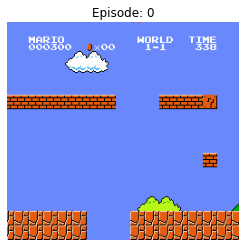

100%|██████████| 1/1 [00:24<00:00, 24.59s/it]

Episode 1 score = 1316.0, average score = 1316.0


{}

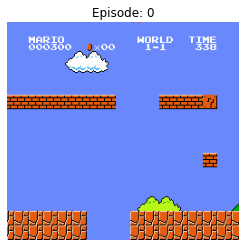

In [ ]:
######test######
# save_root The run folder path after training
# The models in the actions folder are suitable for that type of action
# satrt parameter
#       training_mode=False, pretrained=True means testing
#       double_dqn: True if the model in the folder is DDQN and False if DQN
#       num_episodes: set the number of tests, do not set too large in colab, it is easy to collapse the memory
#       render_mode: display mode, if it is a py file for local testing, it is 0, and ipynb is 1
#       exploration_max: The probability of performing random actions can be set to a very small number during the test
#######Example####
save_root="drive/MyDrive/DQN_DDQN/RIGHT_ONLY_checkpoints/run1/RIGHT_ONLY_ddqn"
actions=RIGHT_ONLY
start(training_mode=False, pretrained=True, double_dqn=True, num_episodes=1, render_mode=1,actions=actions,exploration_max=0.05, save_path=save_root, desc="")
